# Fresnel Wavefront
The `dLux` module offers fully fledged Fresnel optics capabilities based on those in `poppy`. This example shows of how to use the related capabilities.

In [1]:
from matplotlib import pyplot
from astropy import units as u
from jax import numpy as np
import jax
import equinox as eqx
import poppy 
from fresnel import GaussianWavefront, GaussianPropagator, GaussianLens

The first thing to notice is that in `dLux` the `Wavefront` is essentially split over two classes. The reason for this is that the autodiff package we use, `equinox` works by differentiating with respect to class attributes. While we could mix autodiff implementations and use `jax.grad` to take derivatives with respect to function arguments a uniform interface was considered better. 

As a result a `GaussianPropagator` is instantiated whenever we want to take a derivative with respect to a `distance` which is stored as an attribute of the propagator. This means that one `Wavefront` may pass through many propagators. 

A general principle of `dLux` is to abstract mathematically as well as physically, so that the development of physically informed neural network models is easy. The way that this works is the `GaussianPropagator` essentially acts as a differentiable network layer. 

Let's start by using poppy to Fresnel propagate a wavefront through a circular aperture. The parameters I use here come from [this](https://github.com/spacetelescope/poppy/blob/develop/notebooks/Fresnel_Propagation_Demo.ipynb) `poppy` example notebook.

In [2]:
wavefront = poppy.FresnelWavefront(0.5 * u.m, wavelength=2200e-9, npix=256, oversample=4)
wavefront *= poppy.CircularAperture(radius=0.5) 
save = wavefront.wavefront
wavefront.propagate_fresnel(5000 * u.m)
field = wavefront.wavefront

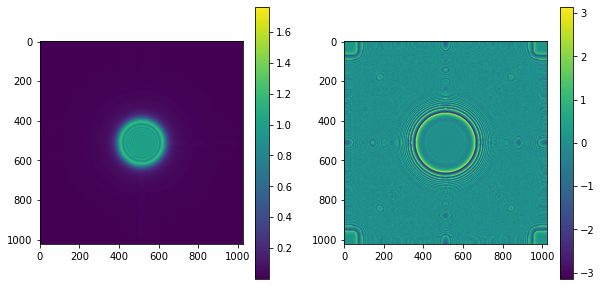

In [3]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(np.abs(field))
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(np.angle(field))
pyplot.colorbar()

Now let's replicate that using `dLux` and it's propagators. Now internally `dLux` nests `PyTree`s and this is something that I am really looking to remove in future versions. But for now we wrap the wavefront in a dictionary to pass it between layers. 

A major difference between `dLux` and `poppy` is that `dLux` doesn't care about units. Everything is in SI units anything else and the code will return incorrect results. This means that all angles are in radians and all distances are in meters with very few exceptions. 

The code is documented with the units so run `help(dLux.Class.method)` to see the units of the parameters. For example, `width : float, meters`, specifies first the type and then the units. 

In [4]:
import dLux
from fresnel import GaussianPropagator, GaussianWavefront, GaussianLens
from jax.config import config

You may notice that we import the `jax.config` module. This is because `JAX` unlike `numpy` automatically processes all floating point operations in `f32`. `JAX` made this choice because it provides native access to `GPU` which are optimised for 32 bit operations. Therefore, we must tell `JAX` that we want to use `f64` instead of `f32`. I have also told `JAX` to through an error when it encounters a `nan` value. This is particularly useful when debugging gradients.

In [5]:
config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

In [6]:
npix = 256 * 4
radius = 0.5 * 4
offset = [0., 0.]
wavelength = 2200e-09

You will notice that when specifying the parameters to the wavefron there are some differences. For example, `oversample` is not a parameter, rather specify the total number of pixels including the oversample (i.e. `256 * 4`). Then you will notice the `offset` parameter, which you can ignore for now (for more information visit [this](https://louisdesdoigts.github.io/dLux/)). Additionally, the wavefront is not completely instantiated by its constructor. We wanted to be able to apply `jax.vmap` a batching transformation over many wavelengths without having to worry about all the meta data associated with the wavefront. As a result the constructor was split into `dLux.CreateWavefront` and `GaussianWavefront.__init__`, which can be frustrating to work with but for now is useful.

In [7]:
wavefront = GaussianWavefront(offset, wavelength, radius)\
    .update_phasor(np.abs(save), np.angle(save))\
    .set_pixel_scale(2 * radius / npix)

Because the constructor does not populate all of the values of the fields we have to set them. `equinox` enforces and immutability requirement onto our classes and as a result `set_...` methods do not work in the usual way. Rather than modifying the state of the class they instead return a modified copy. 

While this takes a bit of getting used to it is convinient in situations where a lot of properties have to be changed at once because you can create streams like above (remembering the `\` line continuation) which are similar to `java` streams our `rust` objects.

We know that our wavefronts match because we stole the electric field of the wavefront from the `poppy` version, but let's check that this is so. To access the field of the wavefront in `dLux` we use `wavefront.get_complex_form`. Internally the wavefront keeps track of the `amplitude` and `phase` separately. In many cases this is advantageous because optical elements may only impact one or the other so the logic in these situations can be simplified. On the other hand it can also be annoying when you want to update both because you have to separate them into `phase` and `amplitude`.

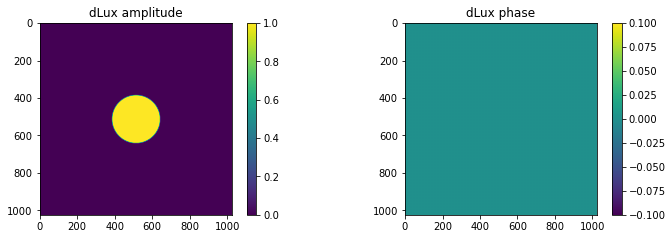

In [8]:
pyplot.figure(figsize=(12, 12))
pyplot.subplot(3, 2, 1)
pyplot.title("dLux amplitude")
pyplot.imshow(wavefront.amplitude)
pyplot.colorbar()

pyplot.subplot(3, 2, 2)
pyplot.title("dLux phase")
pyplot.imshow(wavefront.phase)
pyplot.colorbar()

Another key feature of `dLux` is in how it moves light between optical planes. In `dLux` the propagation of the wavefront is handled by special `Propagator` objects. This is because `equinox` allows us to take derivatives with respect to the attributes of a class. Hence the distance of the propgation must be specified for the `GaussianPropagator` or the `focal_length` for the Fraunhofer propagators. This has the nice effect that both the Fresnel and Fraunhofer regimes are treated very similarly.

In keeping with the poppy example we will propagate our wavefront `5000m` where the units are again assumed. Something that is nice about `dLux` is that we can use the `()()` syntax. `equinox` provides access to OOP in `JAX` which is a functional programming library by registering classes as `PyTree`s. Essentially what this means is that `JAX` thinks your class is some sort of nested `dict`, `list` or `tuple`. 

Patrick Kidger the creator of `equinox` envisaged this system as a way of creating function `partial` like objects that could be initialised and applied to a subset of arguments, whilst still been able to take derivatives and track the frozen arguments. We have followed his style of using the python dunder method `__call__` which essentially turns a class into a `Callable` (a python function).

Applying `__init__` and then `__call__` immediately results in `Class(*args)(*args)` essentially implementing a form of currying for those who are familar. Again this syntax seems very strange at first but becomes very fun once you understand what it is doing. 

In [9]:
wavefront = GaussianPropagator(5000.)(wavefront)

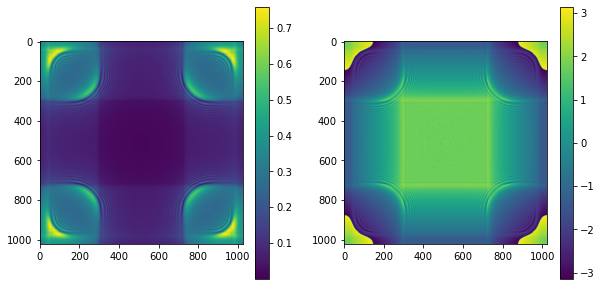

In [10]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(wavefront.amplitude)
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(wavefront.phase)
pyplot.colorbar()

As you can see this matches `poppy`. A word of caution is that the results will never be exactly the same. Because the `Propagator` is kept separate from the `Wavefront` we were able to enforce a rather nice and rather rigid structure onto them. As a result the `_fft` and `_mft` are defined in only one location and shifts are also done here for consistency accross the whole package. `poppy` on the other hand applies the shift once inside the Fourier domain. The end result is that the two will never be exactly the same and often differ by more than `np.allclose` and the best comparisons are always visual.

Autodiff is the reason that we wanted to write `dLux` and as a result I will quickly show you how to implement a derivative. In this case we will look at how fast the `phase` (just the phase not the amplitude) is changing with respect to the propagation distance. 

In [11]:
propagator = GaussianPropagator(5000.)

To use `equinox` fully we must create a filter specification over our `PyTree`. All this means is that of the Frozen parameters what do we want to take the gradient with respect to? The syntax that is required to do this is rather non-trivial but can be done is a line or two. `eqx.tree_at` is a helpful function for traversing and replacing leaves on a `PyTree` (think of specifying the address of an element in a nested `dict`). We must give it a function telling it where to look for example if we had the `PyTree` `[[0., 0.], 1.]` we might provide `lambda tree : tree[0][0]` to tell `equinox` to change that very first `0.`. 

Scale this to a class and we simply need to tell it the name of the attribute. A word of caution, in this highly strange world, PEP8 is not always best. If you were to use `lambda tree : tree.get_distance()` the program would crash. 

The nested function `jax.tree_map` simply walks over the tree and applies the 0th argument which is a function to that leaf and then returns a new `PyTree`. In this case we are creating a `filter_specification` to use so we want to have a boolean `PyTree` with `False` leaves almost everywhere. We then use the `eqx.tree_at` to change the specific leaf on the boolean `PyTree` that we are interested in to `True`.

In [12]:
filter_specification = eqx.tree_at(
    lambda tree : tree.distance, jax.tree_map(lambda _: False, propagator), True)

Because our class is a `PyTree` we can now pass it through functions decorated with the `eqx.filter_grad` element and then call it within the function as a first class function. A note: `functools.partial` is used to create `partial` functions which essentially "freeze" :snowflake: certain arguments. If you are not familar with this concept there are docs available at [this](https://docs.python.org/3/library/functools.html) site.

In [13]:
import functools

In [14]:
@jax.jit
@functools.partial(eqx.filter_grad, arg = filter_specification)
def grad_of_phase_with_distance(propagator, wavefront, i, j):
    wavefront = propagator(wavefront)
    return wavefront.phase[i, j]

In [15]:
phase = np.zeros((11, 11))

In [16]:
# for n, i in enumerate(range(npix // 2 - 5, npix // 2  + 6)):
#     for m, j in enumerate(range(npix // 2 - 5, npix // 2  + 6)):
#         grad = grad_of_phase_with_distance(propagator, wavefront, i, j)
#         phase = phase.at[n, m].set(grad.distance)

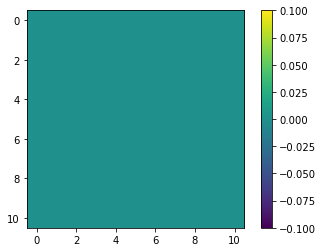

In [17]:
pyplot.imshow(phase)
pyplot.colorbar()

Now `grad` returns the same `PyTree` that it recieved so in this case we need to unpack the `distance` parameter from the variable `grad`. A word of caution the autodiff engine for `JAX` can only differentiate with respect to scalar outputs, hence we in the example above we had to differentiate with respect to just on phase pixel. This is a little frustrating because it means that there is no good way to concurrently take the derivative of the entire pixel grid.

You may have noticed that the above computation is very inefficient. In fact we have to run the propagation for every pixel in the grid, to find the derivative with respect to each pixel at the same time. Normally we could get arround this on a GPU using autobatching. This is best done using the `jax.vmap` transform which concurrently runs the `XLA` on a `GPU` for huge performance boosts.

Let's look at a more complex example using the `GaussianLens` as well as the `GaussianPropagator` and `GaussianWavefront`. The `GaussianLens` is a special type of `Lens` that alters the extra parameters of the `GaussianWavefront` to do with the `GaussianBeam`. In this case we will once again start with the `poppy` version of the code.

In [18]:
aperture = poppy.CircularAperture(radius = 1.)
wavefront = poppy.FresnelWavefront(beam_radius = 1. * u.m, wavelength = 1e-6)
converging = poppy.QuadraticLens(1. * u.m)
diverging = poppy.QuadraticLens(-1. * u.m)

In [19]:
wavefront *= aperture
save = wavefront.wavefront.copy()
wavefront *= converging
wavefront.propagate_fresnel(.5 * u.m)
wavefront *= diverging
wavefront.propagate_fresnel(wavefront.z_w0 - .5 * u.m)

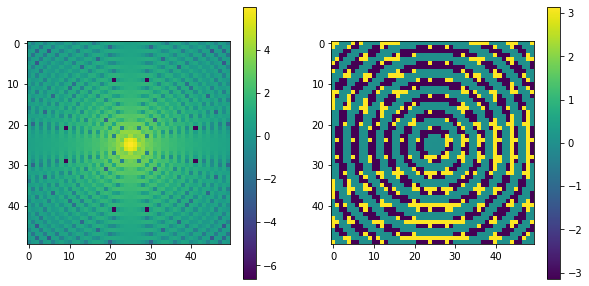

In [33]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(np.log(
    wavefront.amplitude[(1024 - 25):(1024 + 25), (1024 - 25):(1024 + 25)]))
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(wavefront.phase[(1024 - 25):(1024 + 25), (1024 - 25):(1024 + 25)])
pyplot.colorbar()

Now time for the `dLux` implementation. Again we will pirate the `poppy` array after the circular aperture. This is just so that things exactly match on the way in. 

In [21]:
offset = [0., 0.]
wavelength = 1e-6
radius = 1.
npix = wavefront.wavefront.shape[0]

So basically the problem is interfacing the pixel scale between poppy and `dLux`

In [22]:
wave = GaussianWavefront(offset, wavelength, radius)\
    .update_phasor(np.abs(save), np.angle(save))\
    .set_pixel_scale(4 * radius / npix)

In [23]:
wave = GaussianLens(1.)(wave)
wave = GaussianPropagator(.5)(wave)
wave = GaussianLens(-1.)(wave)
wave = GaussianPropagator(wave.waist_position - .5)(wave)

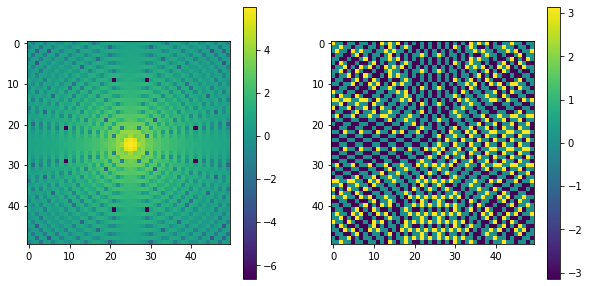

In [34]:
pyplot.figure(figsize=(10, 5))
pyplot.subplot(1, 2, 1)
pyplot.imshow(np.log(wave.amplitude[(1024 - 25):(1024 + 25), (1024 - 25):(1024 + 25)]))
pyplot.colorbar()
pyplot.subplot(1, 2, 2)
pyplot.imshow(wave.phase[(1024 - 25):(1024 + 25), (1024 - 25):(1024 + 25)])
pyplot.colorbar()

You can see that they do not perfectly match, but that the phases are similar in form. This is to be expected because the order of operations differs throughout ad error therefore accrues. 

That is it for the Fresnel demo. Some additional things to note. The `_inside_to_outside` has not been tested yet and may require a fourier shift.